<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
    
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 

<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.




<p></p><p></p><p></p>





**Le problème posé :**


*Stack Overflow est un site célèbre de question-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.*

*Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tags pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.*



**Solutions mises en oeuvre**

Les solutions de suggestion de tags présentés ici se basent sur des modèles *non-supervisés* de machine learning.

Les modèles mis en oeuvre : 
    * Clusterisation par K-means
    * LDA
    * Word2Vec
    * Gloves

Ce notebook utilise les données issues du notebook **P6_DadaAnalysis.ipynb**



In [5]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import p5_util
import p5_util_plot
import p6_util
import p6_util_plot
import p6_util_cluster

# When True, results are read from dumped files.
# Otherwise, results are computed then dumped into files on mass storage.
is_reloaded = True

In [2]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
df_sof_tags.shape

(50000, 2)

In [3]:
df_sof_tags.columns

Index(['TagName', 'Count'], dtype='object')

In [4]:
list_sof_tags = df_sof_tags.TagName.tolist()

# <font color='blus'>3. Unsupervised methods</font>

TAGS are regarded as keywords.

Aims of this section is to create data points then identify clusters from this set of data.

These data-points are digital representation of the cleaned documents dataset.

For each-one of the clusters, most representative terms will be identified.

These terms will be considered as TAGs.

Differents embeddings techniques will be used in order to create data-points : 

* Bag of words
* Co-occurence
* TF-IDF

**Loading train dataset and extract users questions from Body column**

In [5]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
df_sof_train=pd.read_csv(file_name)
print(df_sof_train.shape)

(24604, 5)


**Standardize `Body` column from dataset**

In [ ]:
import p6_util
ser_document_std = p6_util.p6_df_standardization(df_sof_train['Body'],is_stemming=False, is_lem=False)

**Save dataframe with standardized `Body` column**

In [ ]:
import p5_util
file_name="./data/df_document_std.dump"
p5_util.object_dump(ser_document_std, file_name)

**Load standardized corpus**

In [7]:
import p5_util
file_name="./data/ser_sof_train.dump"
ser_sof_train = p5_util.object_load(file_name)
print(ser_sof_train.shape)

#ser_document_std = ser_sof_train[:16359]
ser_document_std = ser_sof_train.copy()
print(ser_document_std.shape)

p5_util.object_load : fileName= ./data/ser_sof_train.dump
(24604,)
(24604,)


#### Corpus vectorization

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# When building vacabulary, terms with frequency document < p_min_df are ignored.
p_min_df = 0.0005

# When building vacabulary, terms with frequency document> p_max_df are ignored.
p_max_df = 0.05


dict_sof_document = ser_document_std.to_dict()

ngram1=1
ngram2=1
vectorizer=TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))

csr_matrix = vectorizer.fit_transform(dict_sof_document.values())

print(csr_matrix.shape)

(24604, 4350)


In [25]:
'd3.js' in vectorizer.vocabulary_

False

**Save vectorization with ngram (1,1) mode**

In [601]:
import p5_util
file_name="./data/csr_matrix_tfidf_"+str(ngram1)+"-"+str(ngram2)+"gram_"+str(p_min_df)+"-"+str(p_max_df)+".dump"
print(file_name)
p5_util.object_dump(csr_matrix, file_name)

file_name="./data/vectorizer_tfidf_"+str(ngram1)+"-"+str(ngram2)+"gram_"+str(p_min_df)+"-"+str(p_max_df)+".dump"
print(file_name)

p5_util.object_dump(vectorizer, file_name)

./data/csr_matrix_tfidf_1-1gram_0.0005-0.05.dump
./data/vectorizer_tfidf_1-1gram_0.0005-0.05.dump


## <font color='blus'>3.1 Kmeans clustering</font>

**Load vectorization operator and CSR matrix**

In [619]:
import p5_util
file_name="./data/csr_matrix_tfidf_"+str(ngram1)+"-"+str(ngram2)+"gram_"+str(p_min_df)+"-"+str(p_max_df)+".dump"
csr_matrix  = p5_util.object_load(file_name)

file_name="./data/vectorizer_tfidf_"+str(ngram1)+"-"+str(ngram2)+"gram_"+str(p_min_df)+"-"+str(p_max_df)+".dump"
vectorizer = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/csr_matrix_tfidf_1-1gram_0.0005-0.05.dump
p5_util.object_load : fileName= ./data/vectorizer_tfidf_1-1gram_0.0005-0.05.dump


### <font color='blus'>3.1.1 Kmeans clustering cross validation</font>

In [5]:
nb_range_cluster1 = range(10,110,10)
nb_range_cluster2 = range(200,600,100)

**Dislay of inter-intertia clustering**

In [623]:
from sklearn.cluster import KMeans
for n_cluster in nb_range_cluster1 :
    cluster_kmean=KMeans(n_clusters=n_cluster,  n_jobs=-1 ).fit(csr_matrix)
    #cluster_kmean_labels = cluster_kmean.labels_.copy()
    file_name = "./data/cluster_kmeans_"+str(n_cluster)+"_"+str(p_max_df)+".dump"
    p5_util.object_dump(cluster_kmean, file_name)
    print("Cluster= "+str(n_cluster)+" Done!")


Cluster= 10 Done!
Cluster= 20 Done!
Cluster= 30 Done!
Cluster= 40 Done!
Cluster= 50 Done!
Cluster= 60 Done!
Cluster= 70 Done!
Cluster= 80 Done!
Cluster= 90 Done!
Cluster= 100 Done!


In [656]:
from sklearn.cluster import KMeans

for n_cluster in nb_range_cluster2 :
    cluster_kmean=KMeans(n_clusters=n_cluster,  n_jobs=-1 ).fit(csr_matrix)
    file_name = "./data/cluster_kmeans_"+str(n_cluster)+"_"+str(p_max_df)+".dump"
    p5_util.object_dump(cluster_kmean, file_name)
    print("Cluster= "+str(n_cluster)+" Done!")


Cluster= 200 Done!
Cluster= 300 Done!
Cluster= 400 Done!
Cluster= 500 Done!


**All saved Kmeans models are reloaded into a dictionary**

In [657]:
dict_kmeans = dict()
count=0
for n_cluster in nb_range_cluster1 :
    file_name = "./data/cluster_kmeans_"+str(n_cluster)+"_"+str(p_max_df)+".dump"
    dict_kmeans[count] = p5_util.object_load(file_name)
    count +=1
for n_cluster in nb_range_cluster2 :
    file_name = "./data/cluster_kmeans_"+str(n_cluster)+"_"+str(p_max_df)+".dump"
    dict_kmeans[count] = p5_util.object_load(file_name)
    count +=1    

p5_util.object_load : fileName= ./data/cluster_kmeans_10_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_20_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_30_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_40_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_50_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_60_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_70_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_80_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_90_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_100_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_200_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_300_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_400_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_500_0.05.dump


10
0 13


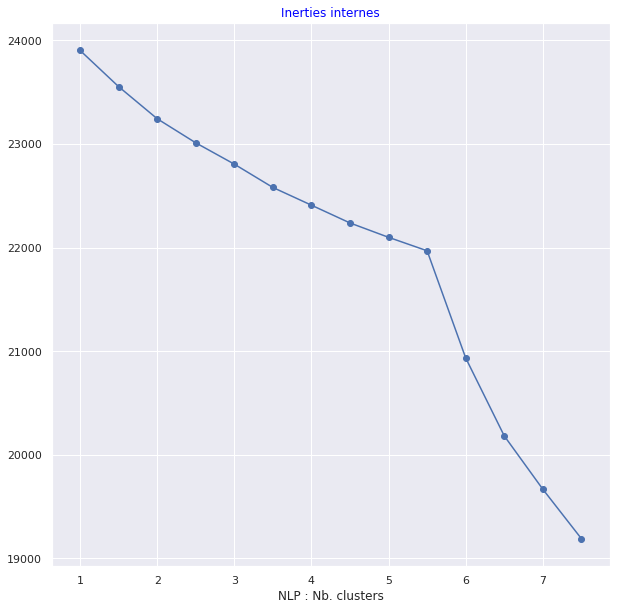

In [668]:
import p5_util_plot
import p5_util

is_reloaded=False
if is_reloaded is True:
    fileName = './data/clustering_dict_kmeans_NLP.dump'
    dict_kmeans = p5_util.object_load(fileName)
    print("Records into Time feaures dict_kmeans= "+str(len(dict_kmeans)))

x_label_0 = 'NLP : Nb. clusters'
x_label_1 = 'NLP : Nb. clusters'
cluster_start = list(dict_kmeans.keys())[0]
print(cluster_start+10)
cluster_end = list(dict_kmeans.keys())[len(dict_kmeans)-1]
print(cluster_start, cluster_end)
p5_util_plot.plot_kmeans_interInertia(dict_kmeans, cluster_start, cluster_end\
                             ,[x_label_0, x_label_1]\
                             ,p_rows=1, p_cols=1, p_figsize=(10,10))

**Save Kmeans clustering**

In [29]:
file_name="./data/cluster_kmeans_labels_"+str(n_cluster)+".dump"
p5_util.object_dump(cluster_kmean_labels, file_name)

**For each cluster build a TAG list**

In [113]:
pf_max=0.05
n_cluster=500
file_name="./data/cluster_kmeans_"+str(n_cluster)+"_"+str(pf_max)+".dump"
cluster_kmean = p5_util.object_load(file_name)
cluster_kmean_labels = cluster_kmean.labels_

p5_util.object_load : fileName= ./data/cluster_kmeans_500_0.05.dump


In [117]:
import p6_util
p_tag_ratio=1.0
dict_dict_list_cluster_tag, dict_cluster_stat, dict_df_freq_cluster_tag, dict_dict_cluster_tag\
= p6_util.get_dict_list_cluster_tag(cluster_kmean_labels, dict_sof_document, vectorizer, p_tag_ratio)

In [131]:
cluster_id=98
dict_list_cluster_tag = dict_dict_cluster_tag[cluster_id]
dict_list_cluster_tag

{'parenthesis': 8.47164762368482,
 'micro': 8.277491609243864,
 'semantics': 7.778500443124875,
 'hell': 7.527186014843968,
 'presumably': 7.349504837606516,
 'closer': 7.282063556810984,
 'nature': 7.016360391077978,
 'macros': 6.999831089126768,
 'lisp': 6.936317683404441,
 'rid': 6.71625579862764,
 'fly': 6.668053696809762,
 'functional': 6.419357071070935,
 'emacs': 6.306683908566822,
 'curious': 5.565527508820516,
 'especially': 5.504902887004081,
 'compiler': 5.400277935925209,
 'syntax': 5.302562463319635,
 'features': 5.1626699641194325,
 'ruby': 4.939004355889163,
 'structure': 4.87238032826057,
 'enough': 4.784555480144979,
 'maybe': 4.742517766949586,
 'language': 4.3989645582438985,
 'far': 4.330783045827826,
 'actually': 4.2928743818459285,
 'lot': 4.259520025806336,
 'much': 3.9035860970923224,
 'object': 3.846674810400549,
 'another': 3.74932952432273,
 'possible': 3.387584861033747,
 'example': 3.380969621915028,
 'procedural': 7.778500443124875,
 'learn': 7.77850044312

In [ ]:
import p5_util
file_name="./data/dict_list_cluster_tag.dump"
p5_util.object_dump(dict_list_cluster_tag, file_name)

#### Plot cluster distribution

In [109]:
import pandas as pd
# Convert dictionary as dataframe allowing having statisticals values
df_cluster_stat = pd.DataFrame.from_dict(dict_cluster_stat, orient='index')
df_cluster_stat.rename(columns={0:'cluster'},inplace=True)

min_cluster_count = min(df_cluster_stat.cluster)
max_cluster_count = max(df_cluster_stat.cluster)

#Get outliers clusters : mix and max values
cluster_max_id = df_cluster_stat.query("cluster == "+str(max_cluster_count), inplace=False).index[0]
cluster_min_id = df_cluster_stat.query("cluster == "+str(min_cluster_count), inplace=False).index[0]

print("Cluster {} : elements= {} ".format(cluster_min_id, min_cluster_count))
print("Cluster {} : elements= {} ".format(cluster_max_id, max_cluster_count))


Cluster 98 : elements= 33 
Cluster 29 : elements= 4140 


**Display Questions distribution among clusters**

In [ ]:
df_cluster_stat.query("cluster <= 1000", inplace=True)
ax = df_cluster_stat.plot.bar(figsize=(7, 7), title="Questions distribution", color='orange', fontsize=14)

**Display cluster with lower number of elements**

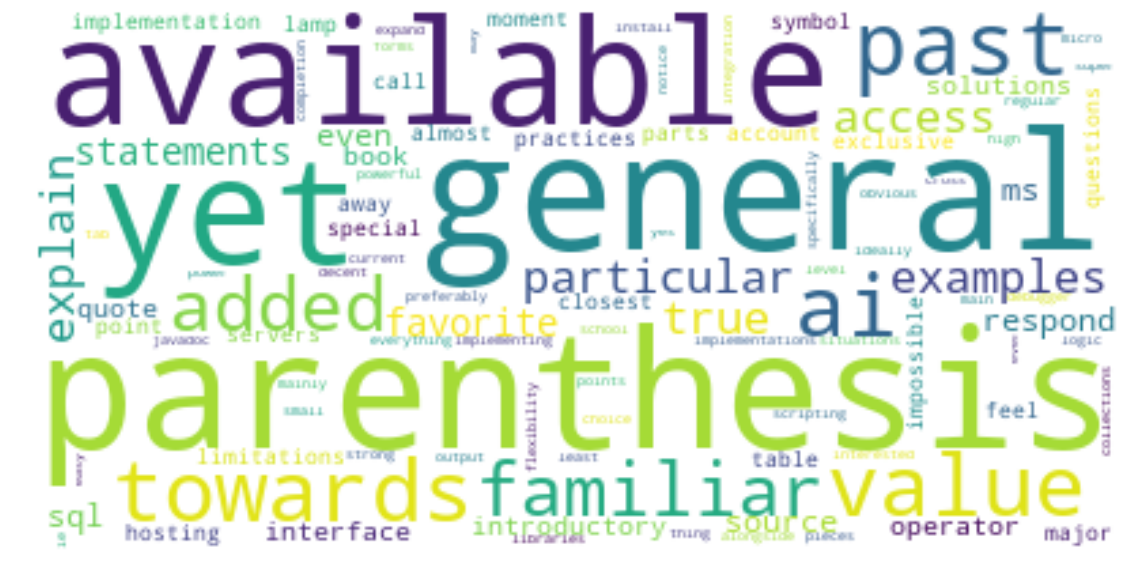

In [111]:
import p6_util_plot
df_freq_cluster_tag = dict_df_freq_cluster_tag[cluster_min_id]
dict_freq_cluster_tag = df_freq_cluster_tag.to_dict()['Freq']
p6_util_plot.display_word_cloud(dict_freq_cluster_tag)

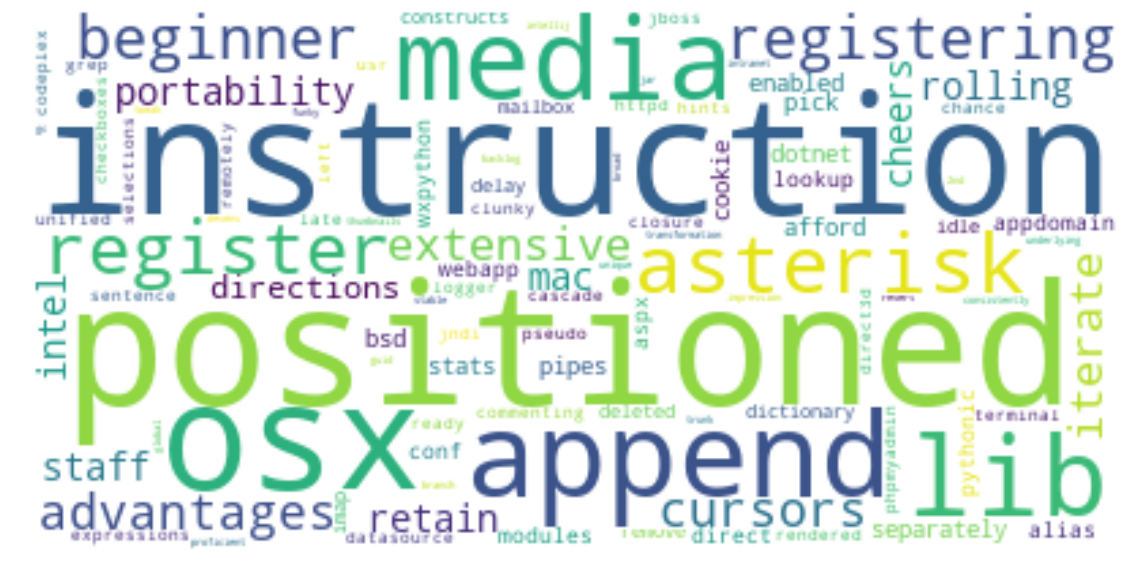

In [112]:
import p6_util_plot
df_freq_cluster_tag = dict_df_freq_cluster_tag[cluster_max_id]
dict_freq_cluster_tag = df_freq_cluster_tag.to_dict()['Freq']
p6_util_plot.display_word_cloud(dict_freq_cluster_tag)

In [ ]:
print(dict_list_cluster_tag[cluster_min_id])
print("\n")
#print(dict_list_cluster_tag[cluster_max_id])

**Display cluster with greater number of elements**

In [ ]:
import p6_util_plot
df_freq_cluster_tag = dict_df_freq_cluster_tag[cluster_max_id]
dict_freq_cluster_tag = df_freq_cluster_tag.to_dict()['Freq']
p6_util_plot.display_word_cloud(dict_freq_cluster_tag)

### <font color='blus'>3.1.2. Kmeans performances evaluation with TFIDF</font>

In [28]:
import pandas as pd

file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)

file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)

list_sof_tags = df_sof_tags.TagName.tolist()

print(df_sof_tags.shape)
'd3.js' in list_sof_tags

(50000, 2)


True

In [604]:
import p6_util_cluster
# Select a document identifier from df_sof_test
doc_id=10
print()
list_suggested_tag, list_assigned_tag, title, post\
=p6_util_cluster.p6_cluster_get_suggested_tag(cluster_kmean, vectorizer, csr_matrix\
                              , df_sof_test, doc_id, cluster_type='kmeans'\
                                              , neighborhood=7, cross_cluster=False)

In [607]:
print("List suggested TAG= "+str(list_suggested_tag))
print()
print("List assigned TAG= "+str(list_assigned_tag))
print("Title= "+str(title))
print()
print("Post= "+str(post))

dict_suggested_tag = dict()
list_intersection_sa = list(set(list_suggested_tag).intersection(list_assigned_tag))
accuracy = len(list_intersection_sa)/len(list_assigned_tag)
dict_suggested_tag[doc_id] = (list_suggested_tag,list_assigned_tag,accuracy)

avg_accuracy=0.0
for tuple_value in dict_suggested_tag.values():
    avg_accuracy += tuple_value[2]
avg_accuracy /=len(dict_suggested_tag)

print("*** Average accuracy for cluster Kmeans= {0:1.2F} ".format(avg_accuracy))

List suggested TAG= ['string', 'representation', 'transfer', 'utf', 'wire', 'transport', 'locale']

List assigned TAG= ['c++', 'unicode', 'locale', 'utf', 'ucs']
Title= UTF usage in C++ code

Post= <p>What is the difference between UTF and UCS.</p>

<p>What are the best ways to represent not European character sets (using UTF) in C++ strings. I would like to know your recommendations for:</p>

<ul>
<li>Internal representation inside the code

<ul>
<li>For string manipulation at run-time</li>
<li>For using the string for display purposes.</li>
</ul></li>
<li>Best storage representation (<b>i.e.</b> In file)</li>
<li>Best on wire transport format (Transfer between application that may be on different architectures and have a different standard locale)</li>
</ul>

*** Average accuracy for cluster Kmeans= 0.40 


In [618]:
nb_test=100
avg_accuracy=0.0
avg_accuracy = p6_cluster_avg_accuracy(nb_test, cluster_kmean, vectorizer, csr_matrix\
                            , df_sof_test, cluster_type='kmeans'\
                            ,neighborhood=3, cross_cluster=True, verbose=False
                           )
print("\n*** Average accuracy for cluster Kmeans= {0:1.2F} ".format(avg_accuracy))


*** ERROR : Exception= The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
*** ****  : list_index = [array([1797, 4249])]

*** ERROR : Exception= The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
*** ****  : list_index = [array([ 255, 2297])]
*** Average accuracy for cluster Kmeans= 0.08 


**All saved Kmeans models are reloaded into a dictionary**

In [11]:
import p5_util
dict_kmeans = dict()
count=0
for n_cluster in nb_range_cluster1 :
    file_name = "./data/cluster_kmeans_"+str(n_cluster)+"_"+str(p_max_df)+".dump"
    kmeans_model = p5_util.object_load(file_name)
    dict_kmeans[count] = (kmeans_model,n_cluster,p_max_df)
    count +=1
for n_cluster in nb_range_cluster2 :
    file_name = "./data/cluster_kmeans_"+str(n_cluster)+"_"+str(p_max_df)+".dump"
    kmeans_model = p5_util.object_load(file_name)
    dict_kmeans[count] = (kmeans_model,n_cluster,p_max_df)
    count +=1    

p5_util.object_load : fileName= ./data/cluster_kmeans_10_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_20_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_30_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_40_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_50_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_60_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_70_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_80_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_90_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_100_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_200_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_300_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_400_0.05.dump
p5_util.object_load : fileName= ./data/cluster_kmeans_500_0.05.dump


In [29]:
import p6_util_cluster

nb_test=50
dict_result_kmean = dict()
for item, tuple_kmean in dict_kmeans.items():
    cluster_kmean = tuple_kmean[0]
    clusters = tuple_kmean[1] 
    avg_accuracy , dict_suggested_tag= p6_util_cluster.p6_cluster_avg_accuracy(nb_test, cluster_kmean, vectorizer, csr_matrix\
                            , df_sof_test, cluster_type='kmeans'\
                            ,neighborhood=3, cross_cluster=True, verbose=False)
    dict_result_kmean[clusters] = (avg_accuracy,dict_suggested_tag)
    print("Model with "+str(clusters)+" clusters  Done!")
#dict_result_kmean

Model with 10 clusters  Done!
Model with 20 clusters  Done!
Model with 30 clusters  Done!
Model with 40 clusters  Done!
Model with 50 clusters  Done!
Model with 60 clusters  Done!
Model with 70 clusters  Done!

*** ERROR : Document position= 236 throwns exception= list index out of range
Model with 80 clusters  Done!
Model with 90 clusters  Done!
Model with 100 clusters  Done!

*** ERROR : Document position= 28 throwns exception= list index out of range

*** ERROR : Document position= 80 throwns exception= list index out of range

*** ERROR : Document position= 129 throwns exception= list index out of range
Model with 200 clusters  Done!

*** ERROR : Document position= 61 throwns exception= list index out of range

*** ERROR : Document position= 95 throwns exception= list index out of range

*** ERROR : Document position= 58 throwns exception= list index out of range
Model with 300 clusters  Done!

*** ERROR : Document position= 62 throwns exception= list index out of range

*** ERROR 

In [15]:
import p5_util
file_name='./data/dict_result_kmean.dump'
p5_util.object_dump(dict_result_kmean,file_name)

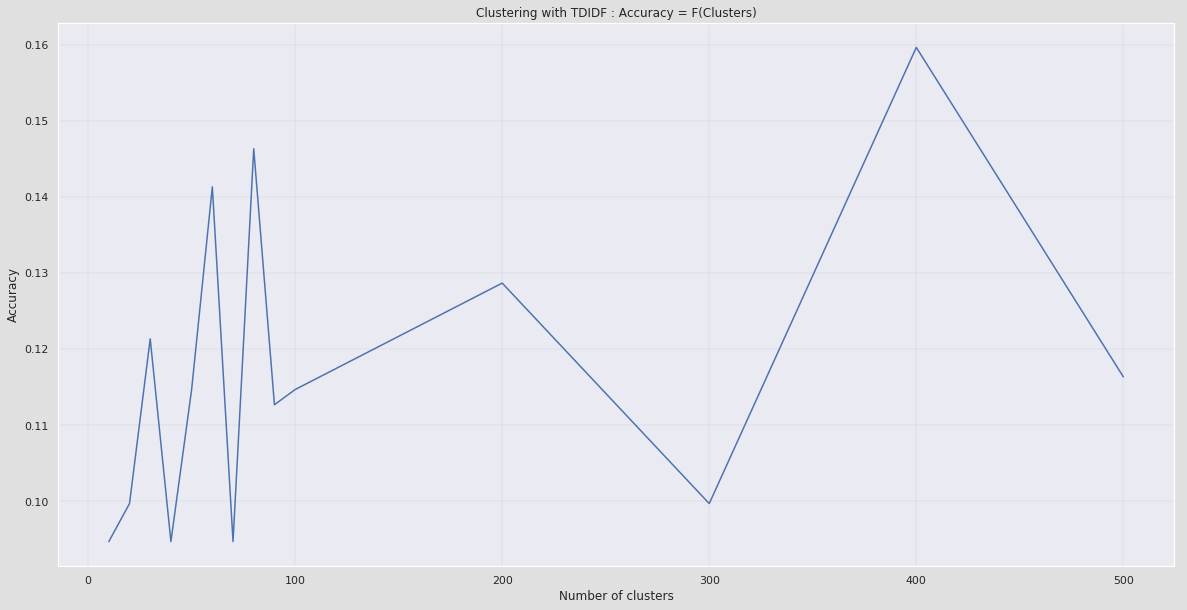

In [61]:
import p6_util_plot
import numpy as np

item_count = None#len(dict_lda_mean_accuracy)

    
X = np.array([key for key in dict_result_kmean.keys()])
y = np.array([value[0] for value in dict_result_kmean.values()])
#X=np.log(X)


title = "Clustering with TDIDF : Accuracy = F(Clusters)"
p_x_title = "Number of clusters"
p_y_title = "Accuracy"
item_count=None
p6_util_plot.X_y_plot(X,y,item_count,title, p_x_title, p_y_title)

**Getting average accuracy =F(dist) : for all clusters**

In [98]:
dict_dist_cluster = dict()
for cluster, dict_result_cluster in dict_result_kmean.items():
    accuracy = dict_result_cluster[0]
    dist=0.
    dict_result_cluster = dict_result_cluster[1]
    for test in dict_result_cluster.keys() :
        #print(dict_result_cluster[test][3])
        dist +=dict_result_cluster[test][3]
    dist /=len(dict_result_cluster)
    dict_dist_cluster[dist] = accuracy


In [99]:
import operator
list_sorted_dist = sorted(dict_dist_cluster.items()\
    , key=operator.itemgetter(0), reverse=False)


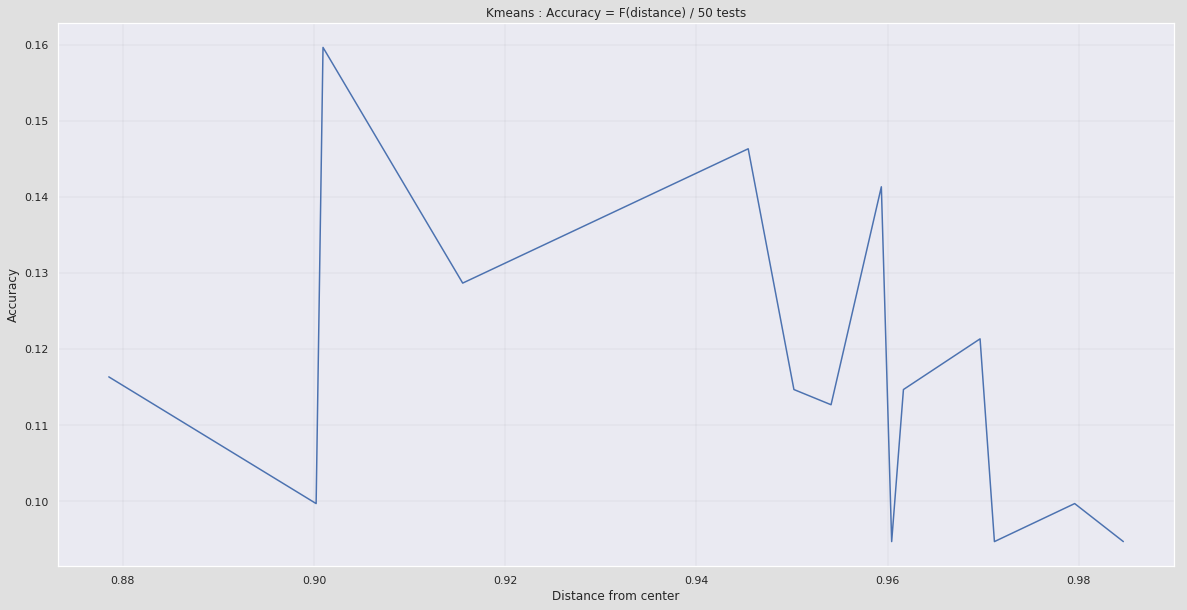

In [100]:
import p6_util_plot
import numpy as np

item_count = None#len(dict_lda_mean_accuracy)

    
X = np.array([item_tuple[0] for item_tuple in list_sorted_dist])

y = np.array([item_tuple[1] for item_tuple in list_sorted_dist])
#X=np.log(X)


title = "Kmeans : Accuracy = F(distance) / 50 tests"
p_x_title = "Distance from center"
p_y_title = "Accuracy"
item_count=None
p6_util_plot.X_y_plot(X,y,item_count,title, p_x_title, p_y_title)

## <font color='blus'>3.3. LDA Performances evaluation with TFIDF</font>

In [1]:
import p5_util
file_name="./data/csr_matrix_tfidf_ngram1_b.dump"
csr_matrix = p5_util.object_load(file_name)

file_name="./data/vectorizer_tfidf_ngram1_b.dump"
vectorizer = p5_util.object_load(file_name)

bow_feature_names = vectorizer.get_feature_names()

embedding_type = "tfidf"

print(csr_matrix.shape)

range_1_topic = range(10,110,10)
range_2_topic = range(200,600,100)

p5_util.object_load : fileName= ./data/csr_matrix_tfidf_ngram1_b.dump
p5_util.object_load : fileName= ./data/vectorizer_tfidf_ngram1_b.dump
(24604, 4791)


### <font color='blue'>3.3.1. Building a set of LDAs models depending of numbers of topics</font>

In [2]:
import p5_util
import p6_util

p6_util.p6_lda_build_range(range_1_topic,embedding_type, csr_matrix)

p6_util.p6_lda_build_range(range_2_topic,embedding_type, csr_matrix)


Building LDA model with 10 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 20 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 30 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 40 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 50 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 60 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 70 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 80 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 90 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 100 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 200 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 300 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 400 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 500 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


### <font color='blue'>3.3.2. LDA performances evaluation with TFIDF</font>

In [3]:
import pandas as pd

file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)

file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)

list_sof_tags = df_sof_tags.TagName.tolist()

print(df_sof_tags.shape)

(50000, 2)


**<font color='blue'>Accuracy score computing for topics ranged from 10 to 100 then 200 to 500</font>**
* For each one of the LDA models ranging from 10 to 100, 1000 random POSTs will be selected from TEST dataset.

* A matching is performed between TAGs issued from POSTs and those issued from LDA model.

* Accuracy is computed from `number of matching TAGs / number of POSTs TAGs`.

* For each model ranging from 10 to 100 topics, results are stored into dictionary and saved into dumped files.


In [9]:
import p6_util
nb_test = 1000

# These fonctions compute dictionaries containing LDA performances.
# Those dictionaries are dumped in files onto mass storage.
# If is_reloaded is True, then those functions are skiped.
is_reloaded=True
if is_reloaded is False :
    p6_util.p6_lda_range_mean_score(nb_test, range_1_topic, embedding_type, df_sof_test\
                            ,list_sof_tags, vectorizer) 

    p6_util.p6_lda_range_mean_score(nb_test, range_2_topic, embedding_type, df_sof_test\
                            ,list_sof_tags, vectorizer) 
else :
    print("\n*** INFO : dictionaries results are still dumped on mass storage !")


*** INFO : dictionaries results are still dumped on mass storage !


**<font color='blue'>Aggregation of ranged scores</font>**

In [9]:
import p6_util
dict_lda_tfidf_mean_accuracy = p6_util.p6_lda_build_accuracy_result(embedding_type, range_1_topic)

for key, value in p6_util.p6_lda_build_accuracy_result(embedding_type, range_2_topic).items():
    dict_lda_tfidf_mean_accuracy[key] = value

p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_10.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_20.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_30.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_40.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_50.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_60.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_70.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_80.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_90.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_100.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_200.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_300.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_400.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_500.dump


**<font color='blue'>Displaying scores</font>**

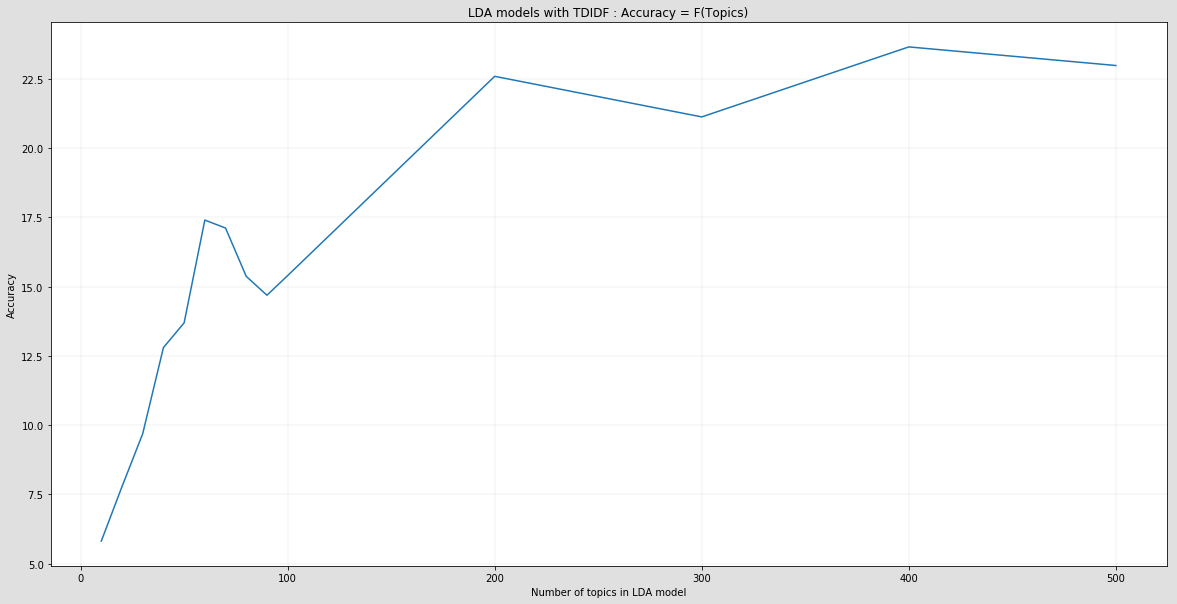

In [8]:
import p6_util_plot
import numpy as np

item_count = None#len(dict_lda_mean_accuracy)

    
X = np.array([key for key in dict_lda_tfidf_mean_accuracy.keys()])
y = np.array([value for value in dict_lda_tfidf_mean_accuracy.values()])
#X=np.log(X)


title = "LDA models with TDIDF : Accuracy = F(Topics)"
p_x_title = "Number of topics in LDA model"
p_y_title = "Accuracy"
item_count=None
p6_util_plot.X_y_plot(X,y,item_count,title, p_x_title, p_y_title)

## <font color='blus'>3.4. LDA with BOW </font>

In [11]:
import p5_util
file_name="./data/csr_matrix_bow.dump"
csr_matrix = p5_util.object_load(file_name)
embedding_type = "bow"

print(csr_matrix.shape)

p5_util.object_load : fileName= ./data/csr_matrix_bow.dump
(24604, 2463)


In [12]:
import p5_util
file_name="./data/vectorizer_bow.dump"
vectorizer = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/vectorizer_bow.dump


In [13]:
bow_feature_names = vectorizer.get_feature_names()

### <font color='blue'>3.4.1. Initializing a set of LDAs models depending of topics numbers</font>

In [ ]:
import p5_util
import p6_util

file_name="./data/csr_matrix_bow.dump"
csr_matrix = p5_util.object_load(file_name)

print(csr_matrix.shape)

p6_util.p6_lda_build_range(range_1_topic,embedding_type, csr_matrix)
p6_util.p6_lda_build_range(range_2_topic,embedding_type, csr_matrix)


### <font color='blue'>3.4.2. LDA performances evaluation with BOW</font>

In [16]:
import pandas as pd
file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)

In [17]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
list_sof_tags = df_sof_tags.TagName.tolist()

df_sof_tags.shape

(50000, 2)

**<font color='blue'>Score computing for topics ranged from 10 to 100</font>**

**<font color='blue'>Score computing for topics ranged from 100 to 600</font>**

In [24]:
import p6_util


dict_dict_score_lda=dict()
nb_test = 1000
embedding_type='bow'
list_sof_tags = df_sof_tags.TagName.tolist()

p6_util.p6_lda_range_mean_score(nb_test, range_1_topic, embedding_type, df_sof_test\
                        ,list_sof_tags, vectorizer) 

p6_util.p6_lda_range_mean_score(nb_test, range_2_topic, embedding_type, df_sof_test\
                        ,list_sof_tags, vectorizer) 

p5_util.object_load : fileName= ./data/lda_bow_10topics.dump
p5_util.object_load : fileName= ./data/lda_bow_20topics.dump
p5_util.object_load : fileName= ./data/lda_bow_30topics.dump
p5_util.object_load : fileName= ./data/lda_bow_40topics.dump
p5_util.object_load : fileName= ./data/lda_bow_50topics.dump
p5_util.object_load : fileName= ./data/lda_bow_60topics.dump
p5_util.object_load : fileName= ./data/lda_bow_70topics.dump
p5_util.object_load : fileName= ./data/lda_bow_80topics.dump
p5_util.object_load : fileName= ./data/lda_bow_90topics.dump
p5_util.object_load : fileName= ./data/lda_bow_100topics.dump


**<font color='blue'>Aggregation of ranged scores</font>**

In [25]:
import p6_util
dict_lda_tfidf_mean_accuracy = p6_util.p6_lda_build_accuracy_result(embedding_type, range_1_topic)

for key, value in p6_util.p6_lda_build_accuracy_result(embedding_type, range_2_topic).items():
    dict_lda_tfidf_mean_accuracy[key] = value

p5_util.object_load : fileName= ./data/dict_score_lda_bow_10.dump
p5_util.object_load : fileName= ./data/dict_score_lda_bow_20.dump
p5_util.object_load : fileName= ./data/dict_score_lda_bow_30.dump
p5_util.object_load : fileName= ./data/dict_score_lda_bow_40.dump
p5_util.object_load : fileName= ./data/dict_score_lda_bow_50.dump
p5_util.object_load : fileName= ./data/dict_score_lda_bow_60.dump
p5_util.object_load : fileName= ./data/dict_score_lda_bow_70.dump
p5_util.object_load : fileName= ./data/dict_score_lda_bow_80.dump
p5_util.object_load : fileName= ./data/dict_score_lda_bow_90.dump
p5_util.object_load : fileName= ./data/dict_score_lda_bow_100.dump
p5_util.object_load : fileName= ./data/dict_score_lda_bow_200.dump
p5_util.object_load : fileName= ./data/dict_score_lda_bow_300.dump
p5_util.object_load : fileName= ./data/dict_score_lda_bow_400.dump
p5_util.object_load : fileName= ./data/dict_score_lda_bow_500.dump


**<font color='blue'>Displaying scores</font>**

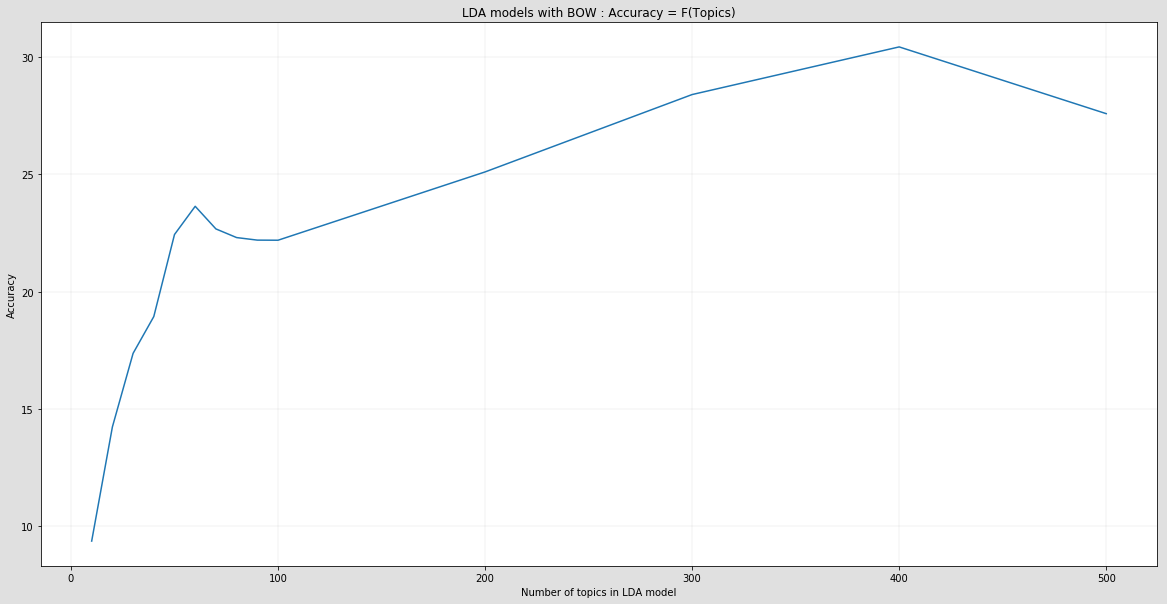

In [26]:
import p6_util_plot
import numpy as np

item_count = None#len(dict_lda_mean_accuracy)

    
X = np.array([key for key in dict_lda_tfidf_mean_accuracy.keys()])
y = np.array([value for value in dict_lda_tfidf_mean_accuracy.values()])
#X=np.log(X)


title = "LDA models with BOW : Accuracy = F(Topics)"
p_x_title = "Number of topics in LDA model"
p_y_title = "Accuracy"
item_count=None
p6_util_plot.X_y_plot(X,y,item_count,title, p_x_title, p_y_title)

**Loading LDA model for 400 topics**

In [1]:
range_topic=range(400,500,100)
for topic in range_topic:
    print(topic)

400


In [10]:
import p5_util
import p6_util

file_name="./data/lda_bow_400topics.dump"
lda_bow_400topics = p5_util.object_load(file_name)


p5_util.object_load : fileName= ./data/lda_bow_400topics.dump


In [11]:
lda_bow_400topics

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=400, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [15]:

for topic_idx, topic in enumerate(lda_bow_400topics.components_):
    print(topic_idx, topic*1000)
    arr_distrib_topic_words = topic
    break
    
#lda_bow_400topics.keys()
type(arr_distrib_topic_words)
lda_bow_400topics.components_[0]

0 [2.50013625 2.50012109 2.50014103 ... 2.50017918 2.50021424 2.50012851]


array([0.00250014, 0.00250012, 0.00250014, ..., 0.00250018, 0.00250021,
       0.00250013])

(array([  3.,   0.,   2.,   4.,   8.,  11.,  19.,  15.,  20.,  37.,  43.,
         46.,  70.,  57.,  85.,  92.,  96., 116.,  97., 129., 117., 126.,
        128., 145., 112., 109., 100., 103., 105.,  79.,  71.,  70.,  50.,
         56.,  33.,  26.,  22.,  13.,  12.,   9.,   5.,   3.,   6.,   5.,
          3.,   0.,   1.,   2.,   1.,   1.]),
 array([0.00250008, 0.00250008, 0.00250008, 0.00250009, 0.00250009,
        0.00250009, 0.00250009, 0.00250009, 0.00250009, 0.00250009,
        0.0025001 , 0.0025001 , 0.0025001 , 0.0025001 , 0.0025001 ,
        0.0025001 , 0.00250011, 0.00250011, 0.00250011, 0.00250011,
        0.00250011, 0.00250011, 0.00250011, 0.00250012, 0.00250012,
        0.00250012, 0.00250012, 0.00250012, 0.00250012, 0.00250013,
        0.00250013, 0.00250013, 0.00250013, 0.00250013, 0.00250013,
        0.00250013, 0.00250014, 0.00250014, 0.00250014, 0.00250014,
        0.00250014, 0.00250014, 0.00250015, 0.00250015, 0.00250015,
        0.00250015, 0.00250015, 0.00250015, 0.

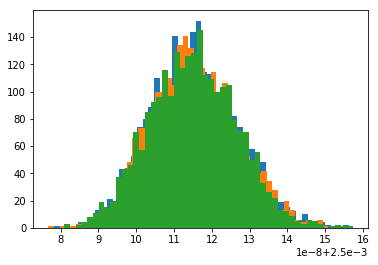

In [16]:
# Distribution of probabilité of P(Tk|Wi) where :
# Tk is the keme topic
# Wi is the ith. word from dictionary

import numpy as np
import matplotlib.pyplot as plt
p_bins=50
plt.hist(lda_bow_400topics.components_[100], bins=p_bins)
plt.hist(lda_bow_400topics.components_[200], bins=p_bins)
plt.hist(lda_bow_400topics.components_[399], bins=p_bins)


## 3.3. DBSCAN clustering

In [ ]:
import p5_util
file_name="./data/csr_matrix_bow.dump"
csr_matrix_bow = p5_util.object_load(file_name)
print(csr_matrix_bow.shape)

file_name="./data/vectorizer_bow.dump"
vectorizer_bow = p5_util.object_load(file_name)

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

p_eps=5
# ALL CPU are activated
dbscan = DBSCAN(eps=p_eps,min_samples=100, n_jobs=-1)


pred_dbscan =  dbscan.fit_predict(csr_matrix_bow.toarray())

np.unique(pred_dbscan)

In [ ]:
print("Noise : "+str(len(np.where(pred_dbscan==-1)[0])))
print("Classified : "+str(len(np.where(pred_dbscan!=-1)[0])))

CSR matrix is converted into dataframe in order to feed cluster algorithm

In [32]:
import pandas as pd
df_sof = pd.DataFrame(csr_matrix.toarray())
print(df_sof.shape)

(24604, 4207)


In [36]:
import p5_util
cluster_start = 1
cluster_end = 201
dict_kmeans = p5_util.kmeans_scan_inter_inertia(df_sof, cluster_start, cluster_end)

Clustering : 1 clusters
Clustering : 2 clusters
Clustering : 3 clusters
Clustering : 4 clusters
Clustering : 5 clusters
Clustering : 6 clusters
Clustering : 7 clusters
Clustering : 8 clusters
Clustering : 9 clusters
Clustering : 10 clusters
Clustering : 11 clusters
Clustering : 12 clusters
Clustering : 13 clusters
Clustering : 14 clusters
Clustering : 15 clusters
Clustering : 16 clusters
Clustering : 17 clusters
Clustering : 18 clusters
Clustering : 19 clusters
Clustering : 20 clusters
Clustering : 21 clusters
Clustering : 22 clusters
Clustering : 23 clusters
Clustering : 24 clusters
Clustering : 25 clusters
Clustering : 26 clusters
Clustering : 27 clusters
Clustering : 28 clusters
Clustering : 29 clusters
Clustering : 30 clusters
Clustering : 31 clusters
Clustering : 32 clusters
Clustering : 33 clusters
Clustering : 34 clusters
Clustering : 35 clusters
Clustering : 36 clusters
Clustering : 37 clusters
Clustering : 38 clusters
Clustering : 39 clusters
Clustering : 40 clusters
Clusterin

In [37]:
len(dict_kmeans)

200

**Save Kmeans clustering scan**

In [39]:
import p5_util

fileName = './data/dict_tfidf_clustering_kmeans_'+str(len(dict_kmeans))+'.dump'
p5_util.object_dump(dict_kmeans, fileName)

In [40]:
fileName

'./data/dict_tfidf_clustering_kmeans_200.dump'

1 200


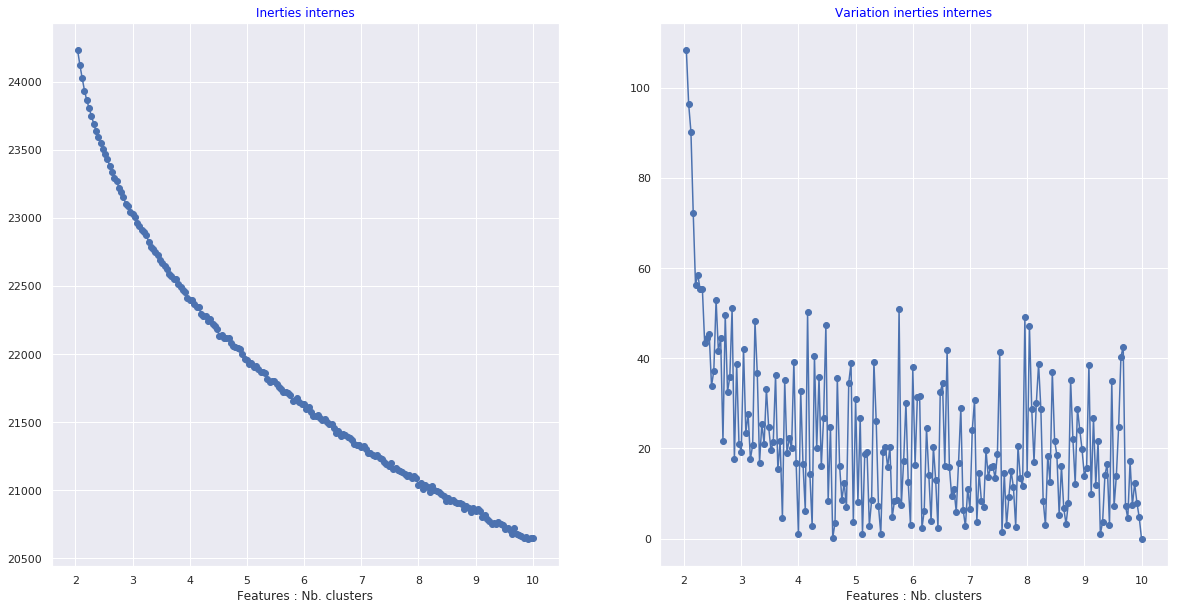

In [41]:
import p5_util_plot
import p5_util
is_reloaded = False
if is_reloaded is True:
    fileName = './data/dict_tfidf_clustering_kmeans.dump'
    dict_kmeans = p5_util.object_load(fileName)
    print("Records into dict_kmeans= "+str(len(dict_kmeans)))
fileNamefileName
x_label_0 = 'Features : Nb. clusters'
x_label_1 = 'Features : Nb. clusters'
cluster_start = list(dict_kmeans.keys())[0]
cluster_end = list(dict_kmeans.keys())[len(dict_kmeans)-1]
print(cluster_start, cluster_end)
p5_util_plot.plot_kmeans_interInertia(dict_kmeans, cluster_start, cluster_end\
                             ,[x_label_0, x_label_1]\
                             ,p_rows=1, p_cols=2, p_figsize=(20,10))

In [43]:
dict_kmeans[8]

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## <font color='blus'>3.5. Word2Vec model</font>

### Embedding corpus with Word2vec model

It is expected that ``word2vec`` learns relationships between words automatically.

* ``df_sof_train['Body']`` represents the corpus with which ``word2vec`` model is feeded.
* Once feed, ``word2vec`` will build a vocabulary, mean, a list of words (features) from which any word from corpus is vectorized.
* Matrix [Corpus words x Features] is stored in ``word2vec_model.wv.vectors``.


**<font color='blue'>Load test dataset</font>**

In [6]:
import pandas as pd

file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)

file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)

list_sof_tags = df_sof_tags.TagName.tolist()

print(df_sof_tags.shape)

(50000, 2)


**<font color='blue'>Load train dataset</font>**

In [23]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
df_sof_train=pd.read_csv(file_name)
print(df_sof_train.shape)

(24604, 5)


**<font color='blue'>Load standardized corpus</font>**

In [1]:
import p5_util
file_name="./data/ser_sof_train.dump"
ser_sof_train = p5_util.object_load(file_name)
print(ser_sof_train.shape)

p5_util.object_load : fileName= ./data/ser_sof_train.dump
(24604,)


In [2]:
import p6_util

df_sof_train = ser_sof_train.to_frame()

list_sentence = p6_util.get_list_sentence_from_df(df_sof_train, 'Body')
len(list_sentence)

24604

In [3]:
list_sentence[0]

['track',
 'bar',
 'form',
 's',
 'opacity',
 'this',
 'code',
 'control',
 'work',
 'this',
 'code',
 'fine',
 'past',
 'vb',
 'net',
 'project',
 'convert',
 'decimal',
 'double']

### <font color='blus'>3.5.1. Train Word2Vec model for size ranging from 100 to 1000</font>

In [4]:
from gensim.models import Word2Vec
import p5_util
import p6_util

#sg=0 : CBOW is used
#sg=1 : skip gram is used
dict_w2vec_model = dict()
size_range = range(100,1100,100)
for p_size in size_range :
    word2vec_model = Word2Vec(list_sentence, min_count=2, size=p_size, workers=6, sg=0, window=5)
    word2vec_model.train(list_sentence, total_examples=len(list_sentence), epochs=10)
    dict_w2vec_model[p_size] = word2vec_model
    print(word2vec_model)

fileName = "./data/dict_w2vec_model"
p5_util.object_dump(dict_w2vec_model, fileName)

Word2Vec(vocab=18444, size=100, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=300, alpha=0.025)
Word2Vec(vocab=18444, size=400, alpha=0.025)
Word2Vec(vocab=18444, size=500, alpha=0.025)
Word2Vec(vocab=18444, size=600, alpha=0.025)
Word2Vec(vocab=18444, size=700, alpha=0.025)
Word2Vec(vocab=18444, size=800, alpha=0.025)
Word2Vec(vocab=18444, size=900, alpha=0.025)
Word2Vec(vocab=18444, size=1000, alpha=0.025)


**<font color='blue'>W2Vec model accuracy</font>**

In [7]:
import p6_util
dict_w2vec_mean_accuracy = dict()
for p_size in size_range :
    dict_w2vec_mean_accuracy[p_size] \
    = p6_util.p6_w2vec_mean_accuracy(dict_w2vec_model[p_size], df_sof_test, ratio=1/100)
    print("\n*** Mean accuracy for Word2Vec("+str(p_size)+") = {0:1.2F}".format(dict_w2vec_mean_accuracy[p_size]*100))


*** INFO : NB test= 163

*** Mean accuracy for Word2Vec(100) = 21.36

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec(200) = 21.24

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec(300) = 21.11

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec(400) = 21.76

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec(500) = 21.28

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec(600) = 20.97

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec(700) = 21.27

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec(800) = 22.78

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec(900) = 21.61

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec(1000) = 21.97


### <font color='blus'>3.5.2. Train Word2Vec model for window ranging from 1 to 10</font>

In [12]:
from gensim.models import Word2Vec
import p5_util
import p6_util

#sg=0 : CBOW is used
#sg=1 : skip gram is used
p_size = 200
dict_w2vec_model = dict()
window_range = range(1,21,1)
for p_window in window_range :
    word2vec_model = Word2Vec(list_sentence, min_count=2, size=p_size, workers=6, sg=0, window=p_window)
    word2vec_model.train(list_sentence, total_examples=len(list_sentence), epochs=10)
    dict_w2vec_model[p_window] = word2vec_model
    print("Window= "+str(p_window)+" / {}".format(word2vec_model)

fileName = "./data/dict_w2vec_model_window"
p5_util.object_dump(dict_w2vec_model, fileName)

Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)
Word2Vec(vocab=18444, size=200, alpha=0.025)


**<font color='blue'>W2Vec model accuracy</font>**

In [75]:
import p6_util
post_id=300
body  = df_sof_test.Body.iloc[post_id]
title = df_sof_test.Title.iloc[post_id]
tags  = df_sof_test.Tags.iloc[post_id]
post  = body+title
ser_post = p6_util.p6_str_standardization(post)
list_post_word = ser_post.tolist()[0].split()
list_tag_expert = word2vec_model.predict_output_word(list_post_word, topn=10)
print(list(set(list_tag_expert).intersection(list_sof_tags)))
print(list_tag_expert)
print()
print(body)
print()
print(title)
print()
print(tags)

[]
[('lib', 0.51791024), ('name', 0.34205732), ('dir', 0.0077024354), ('cpp', 0.0052703572), ('fatal', 0.004975718), ('error', 0.004882041), ('h', 0.0048304675), ('usr', 0.0041413927), ('path', 0.0040876283), ('directory', 0.003691896)]

<p>i have the following script</p>

<pre><code>import getopt, sys
opts, args = getopt.getopt(sys.argv[1:], "h:s")
for key,value in opts:
    print key, "=&gt;", value
</code></pre>

<p>if i name this getopt.py and run it doesn't work as it tries to import itself</p>

<p>is there a way around this, so i can keep this filename but specify on import that i want the standard python lib and not this file?  </p>

<p>Solution based on Vinko's answer:</p>

<pre><code>import sys
sys.path.reverse()
from getopt import getopt

opts, args = getopt(sys.argv[1:], "h:s")

for key,value in opts:
    print key, "=&gt;", value
</code></pre>


python name a file same as a lib

<python>


In [13]:
import p6_util

dict_w2vec_mean_accuracy = dict()
for p_window in window_range :
    dict_w2vec_mean_accuracy[p_window] \
    = p6_util.p6_w2vec_mean_accuracy(dict_w2vec_model[p_window], df_sof_test, ratio=1/100)
    print("\n*** Mean accuracy for Word2Vec( window="+str(p_window)+") = {0:1.2F}".format(dict_w2vec_mean_accuracy[p_window]*100))


*** INFO : NB test= 163

*** Mean accuracy for Word2Vec( window=1) = 14.51

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec( window=2) = 17.47

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec( window=3) = 19.41

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec( window=4) = 21.04

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec( window=5) = 22.25

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec( window=6) = 22.47

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec( window=7) = 24.03

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec( window=8) = 23.47

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec( window=9) = 23.72

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec( window=10) = 23.16

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec( window=11) = 23.42

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec( window=12) = 24.16

*** INFO : NB test= 163

*** Mean accuracy for Word2Vec( window=13) = 24.58

*** INF

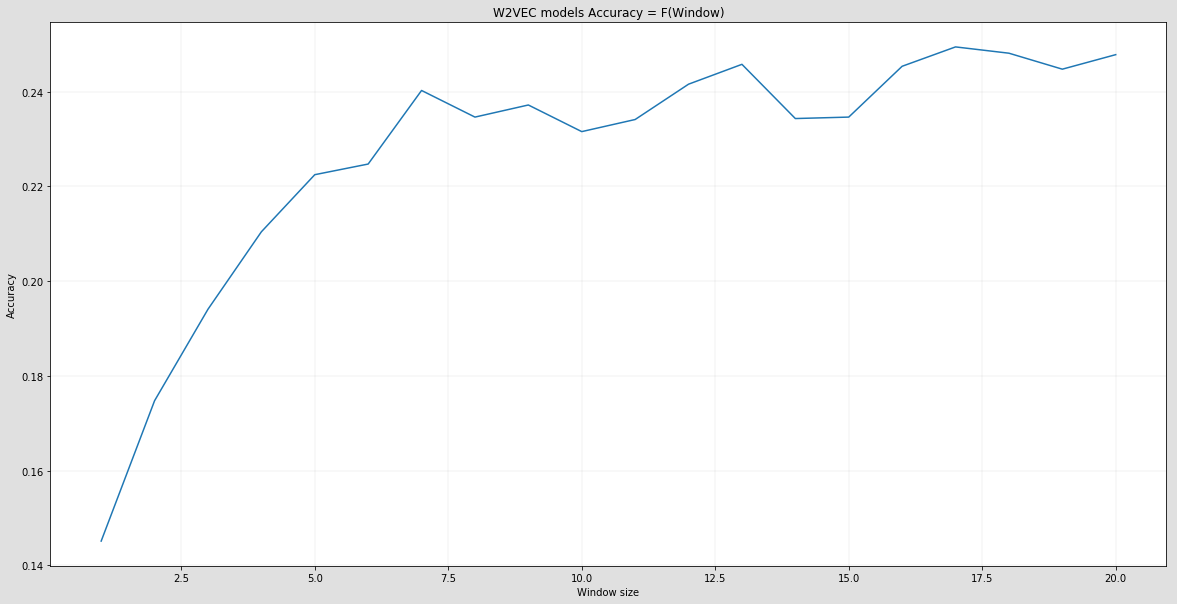

In [14]:
import p6_util_plot
import numpy as np

item_count = None#len(dict_lda_mean_accuracy)

    
X = np.array([key for key in dict_w2vec_mean_accuracy.keys()])
y = np.array([value for value in dict_w2vec_mean_accuracy.values()])
#X=np.log(X)


title = "W2VEC models Accuracy = F(Window)"
p_x_title = "Window size"
p_y_title = "Accuracy"
item_count=None
p6_util_plot.X_y_plot(X,y,item_count,title, p_x_title, p_y_title)

**<font color=blue>Save best W2VEC model**</font>

In [16]:
import p5_util
window=7
size=200
file_name="./data/w2vec_best_model"
p5_util.object_dump(dict_w2vec_model[window],file_name)

### <font color='blus'>3.5.2. Build dictionary from TAG suggested by an expert solution</font>

In [47]:
import pandas as pd
file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)
print(df_sof_test.shape, df_sof_test.columns)

(16359, 5) Index(['Id', 'PostTypeId', 'Body', 'Title', 'Tags'], dtype='object')


In [48]:
file_name="./data/w2vec_best_model"
w2vec_best = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/w2vec_best_model


In [32]:
import p6_util

id_post=500
#for post_id in range(0,nb_post) :
list_post_word = df_sof_test.tolist()[id_post].split()
list_tag_suggested \
    = w2vec_best.predict_output_word(list_post_word, topn=10)
list_tag_suggested=[tuple_result[0] for tuple_result in list_tag_suggested]
print(list_tag_suggested)
print(p6_util.clean_marker_text(df_sof_train.Tags[id_post],leading_marker='<', trailing_marker='>'))
print(df_sof_train.Title[id_post])
print()
print(df_sof_train.Body[id_post])


['dll', 'assembly', 'assemblies', 'dlls', 'gac', 'version', 'library', 'exe', 'loaded', 'folder']
['c#', '.net', 'sharepoint', 'assemblies']
How to reference to multiple version assembly

<p>I'm developing a Sharepoint application and use .NET AjaxControlToolkit library, we are adding a custom aspx page to the Sharepoint. Sharepoint 2007 run in quirks mode so I've made some modification to the AJAX library to make it behave like it normally should. The problem is, the other team already use AJAX library and it is a different version with mine. This cause conflict because there could be only one dll in the bin folder with the same name.</p>

<p>From what I know, .NET should be able to handle this situation easily. I've tried using strong name and GAC to solve it, but it still refer to the dll in the bin folder. If there is no AjaxControlToolkit.dll in the bin folder, the application will simply fail to load the assembly. </p>

<p>If I use complete assembly information on my like this </

In [57]:
import p6_util
nb_test=df_sof_test.shape[0]
dict_post_w2vec_tag , nb_fail= p6_util.w2vec_build_dict_post_tag(w2vec_best , df_sof_test, nb_test, topn=10)

/home/bangui/anaconda3/lib/python3.7/site-packages/gensim/models/word2vec.py:859: UserWarning: All the input context words are out-of-vocabulary for the current model.
  warnings.warn("All the input context words are out-of-vocabulary for the current model.")


POST= 8172 Nb suggested TAG= None


In [58]:
import p5_util
file_name="./data/dict_post_w2vec_tag"
p5_util.object_dump(dict_post_w2vec_tag,file_name)

In [61]:
df_sof_test.Title[8172]

'<noscript> in <head>'

## <font color='blus'>3.6. Glove model</font>

In [ ]:
import itertools
#from gensim.models.word2vec import Text8Corpus
from glove import Corpus, Glove

# sentences and corpus from standard library
#sentences = list(itertools.islice(Text8Corpus('text8'),None))
corpus = Corpus()
# fitting the corpus with sentences and creating Glove object
corpus.fit(list_tokenized_sentences, window=10)
glove = Glove(no_components=100, learning_rate=0.05)
# fitting to the corpus and adding standard dictionary to the object
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

# <font color='blus'>4. Test and performance</font>

**Dictionary of tags from expert solution is loaded**

In [42]:
import p5_util
file_name="./data/dict_post_w2vec_tag"
dict_post_w2vec_tag = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/dict_post_w2vec_tag


**Test dataset is loaded**

In [43]:
import pandas as pd

file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)

file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)

list_sof_tags = df_sof_tags.TagName.tolist()

print(df_sof_tags.shape)

(50000, 2)


## <font color='blus'>4.1 Computation of accuracy, recall and F-measure</font>

In [44]:
df_sof_test.columns

Index(['Id', 'PostTypeId', 'Body', 'Title', 'Tags'], dtype='object')

In [ ]:
p6_util.measure_avg_compute(dict_post_w2vec_tag,df_sof_test.Tags)

### Word2Vec model

* A post is randomly selected from test dataset.
* Then post is ipre-processed in order to feed M.L. model.

* Tag counts is computed from test.
* Computed tags are returned with same number and same format then tags from test.

In [ ]:
import p6_util
tag_count=p6_util.get_tag_count(df_sof_test.Tags.iloc[i_random])

list_computed_tag = p6_util.get_list_tag_from_post(df_post.Body.iloc[0], word2vec_model, max_tag=tag_count)
print("Computed tags = "+"".join(list_computed_tag))
print("")
print("Tags from test = "+df_sof_test.Tags.iloc[i_random])
print("------------------------------------------")
print("Posted question : \n")
print("Title : "+str(title))
print("")
print("Body: "+str(body))

## Plot 2D projection of Word2Vec embedded vocabulary

In [ ]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec.load("word2vec_model")

len(word2vec_model.wv.vocab.keys()), len(word2vec_model.wv.vectors)

### Compute matrix for any word into corpus

**Load cleaned train-dataset**

In [ ]:
import p5_util
file_name='./data/df_sof_train.dump'
df_sof_train=p5_util.object_load(file_name)

**Get SOF corpus from dataframe**

In [ ]:
import p6_util
list_corpus = p6_util.get_list_sentence_from_df(df_sof_train, 'Body')

In [ ]:
list_tokenized_corpus=list()
i=0
for list_word in list_corpus:
    list_tokenized_corpus += list_word
    

In [ ]:
len(list_tokenized_corpus[1:]), len(list_tokenized_corpus)

### 2D t-SNE transformation

#### Load TDIF Matrix

In [10]:
import p5_util
file_name="./data/csr_matrix_tdif.dump"
csr_matrix = p5_util.object_load(file_name)

print(csr_matrix.shape)

p5_util.object_load : fileName= ./data/csr_matrix_tdif.dump
(24604, 1363)


**Get sample from CSR matrix**

In [12]:
import random
import numpy as np
arr = np.zeros(100)
array = csr_matrix.toarray()
#array_index_sample = random.sample(list(csr_matrix.shape), 10)

arr_index = np.random.randint(0,array.shape[0],1000)
array_sample = csr_matrix.toarray()[arr_index]

In [13]:
array_sample.shape, array.shape

((1000, 1363), (24604, 1363))

**Compute for embedded vocabulary t-SNE projection with different perplexity values**

In [33]:
import p5_util
if True:
    #X_std=word2vec_model.wv.vectors
    X_std = array_sample
    my_list_tsne_perplexity=[var for var in range(5,55,5)]
    dict_tsne_result = p5_util.tsne_2D_process_perplexity(X_std, tsne_iter=500, list_tsne_perplexity=my_list_tsne_perplexity)

tSNE perplexity : 5/50 ...
tSNE perplexity : 10/50 ...
tSNE perplexity : 15/50 ...
tSNE perplexity : 20/50 ...
tSNE perplexity : 25/50 ...
tSNE perplexity : 30/50 ...
tSNE perplexity : 35/50 ...
tSNE perplexity : 40/50 ...
tSNE perplexity : 45/50 ...
tSNE perplexity : 50/50 ...


**Plot points issued from t-SNE transformations for each perplexity value**

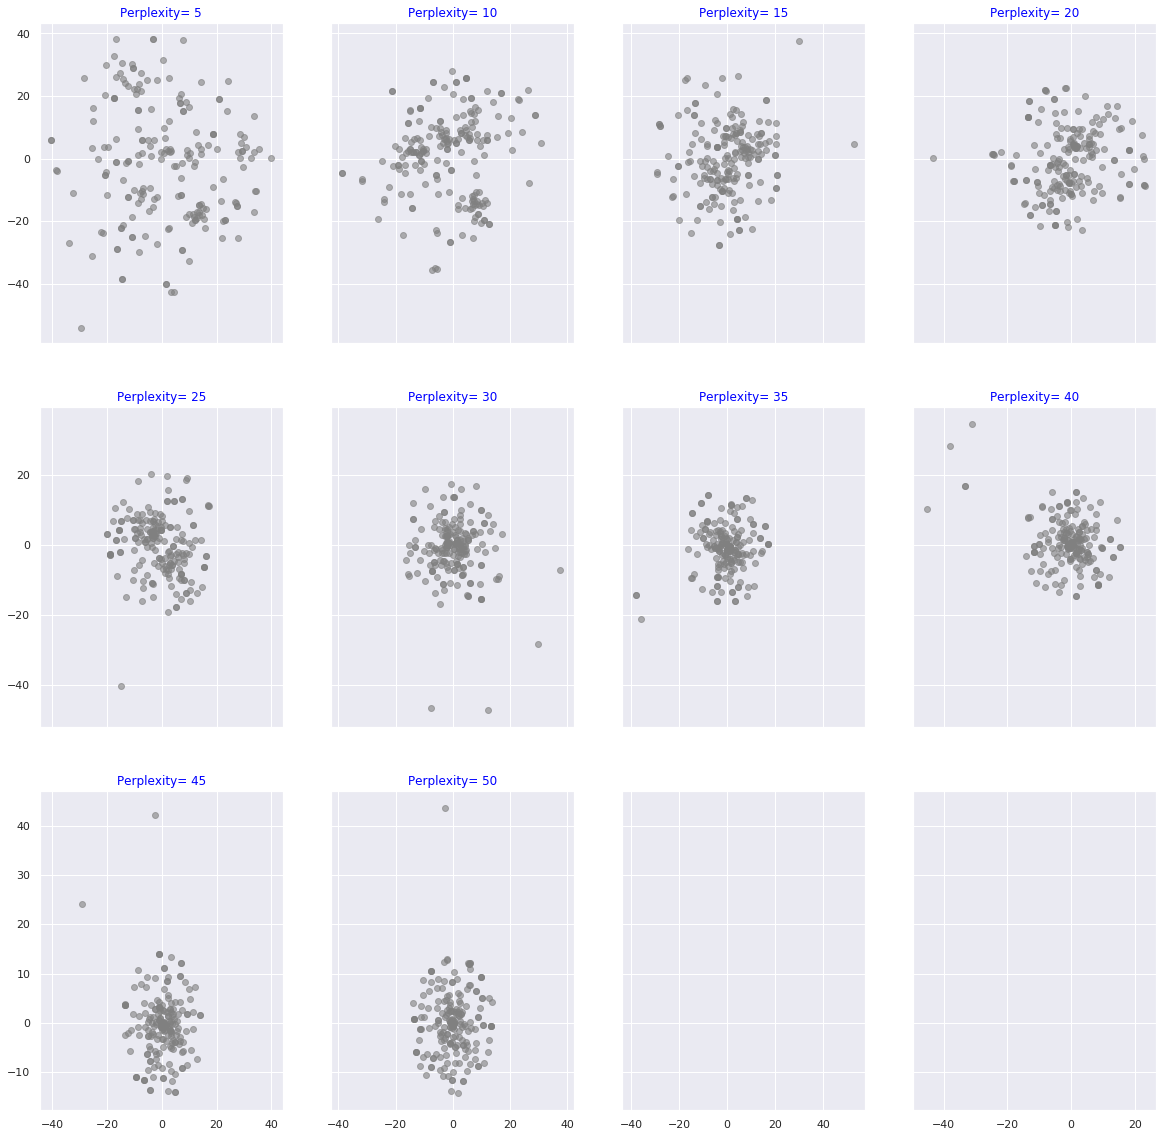

In [37]:
import p5_util_plot
if True :
    nb_col = 4     
    p5_util_plot.plot_2D_dict_tsne_result(dict_tsne_result, nb_col, ratio=0.2)

**Compute vocabulary t-SNE transformation for a fixed perplexity value**

In [36]:
dict_tsne_result_perplexity = dict()

In [40]:
import p5_util
window=7
size=200
file_name="./data/w2vec_best_model"
word2vec_model = p5_util.object_load(file_name)

X_std=word2vec_model.wv.vectors
print(X_std.shape)
perplexity=25

my_list_tsne_perplexity=[perplexity,]
dict_tsne_result_perplexity = p5_util.tsne_2D_process_perplexity(X_std, tsne_iter=500\
                                                                 , list_tsne_perplexity=my_list_tsne_perplexity)

p5_util.object_load : fileName= ./data/w2vec_best_model
(18444, 200)
tSNE perplexity : 25/50 ...


In [21]:
len(dict_tsne_result_perplexity[perplexity]),X_std.shape

(18444, (18444, 200))

**Plot points issued from t-SNE embedded vocabulary transformation with words related to each point**

In [39]:
import numpy as np
import p5_util_plot

nb_col = 1

dict_tsne_result_part={perplexity:dict_tsne_result_perplexity[perplexity]}
    
p_annotation = np.array(list(word2vec_model.wv.vocab.keys()))
p5_util_plot.plot_2D_dict_tsne_result(dict_tsne_result_part, nb_col, ratio=0.01, annotation=p_annotation)

KeyError: 10

### 2D PCA transformation

In [ ]:
import pandas as pd
df_pca=pd.DataFrame(X_std)

In [ ]:
df_pca.shape

In [ ]:
import p3_util_plot
z__ = p3_util_plot.df_pca_all_plot(df_pca, plot=True)

In [ ]:
from sklearn.decomposition import PCA

nb_components=600
pca = PCA(n_components=nb_components)
pca.fit(X_std)
X_pca = pca.transform(X_std)
print(X_pca.shape)

**Save reduced PCA**

In [ ]:
import p5_util
file_name="./data/pca_600_tdif.dump"
p5_util.object_dump(X_pca, file_name)

In [ ]:
import p3_util_plot
p_ratio=0.1
title = str(int(p_ratio*100))+" % Embedded TF-IDF vocabulary"
pca_=p3_util_plot.df_pca_components_plot(df_pca, None, nb_components=2, param_title=title, ratio=p_ratio)

In [ ]:
df_pca.shape

In [ ]:
import pandas as pd

list(word2vec_model.wv.vocab.keys())
df_vocab=pd.DataFrame(list(word2vec_model.wv.vocab.keys()))

In [ ]:
df_vocab.shape

In [ ]:
import p3_util_plot

p3_util_plot.df_pcs2_plot(df_pca, pca_)

In [8]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pandas as pd
token_pred=['zos','que','moi']
list_col_true=['z/os','etait','une','fois']
list_tuple_score = process.extract(token_pred[0], list_col_true)
list_tuple_score

[('z/os', 86), ('fois', 57), ('etait', 0), ('une', 0)]

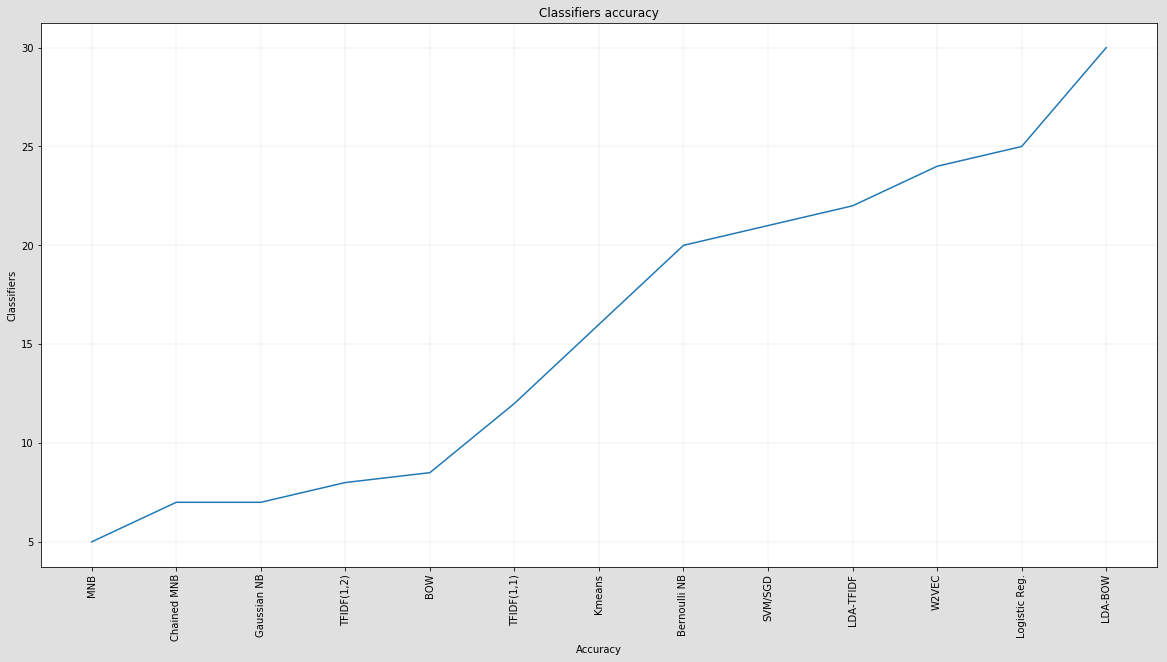

In [2]:
import p6_util
dict_benchmark_result = dict()
dict_benchmark_result['TFIDF(1,2)']=8.0/100
dict_benchmark_result['BOW']=8.5/100
dict_benchmark_result['TFIDF(1,1)']=12/100
dict_benchmark_result['Kmeans']=16/100
dict_benchmark_result['LDA-TFIDF']=22/100
dict_benchmark_result['LDA-BOW']=30/100
dict_benchmark_result['W2VEC']=24/100
dict_benchmark_result['MNB']=5/100
dict_benchmark_result['SVM/SGD']=21/100
dict_benchmark_result['Bernoulli NB']=20/100
dict_benchmark_result['Logistic Reg.']=25/100
dict_benchmark_result['Chained MNB']=7./100
dict_benchmark_result['Gaussian NB']=7./100



import pandas as pd
df_result = pd.DataFrame.from_dict( dict_benchmark_result, orient='index')
df_result.reset_index(inplace=True)
df_result.rename(columns={'index':'Classifier',0:'Score'}, inplace=True)
df_result

import p6_util_plot
title = "Classifiers accuracy"
p6_util_plot.ser_item_occurency_plot(df_result.Classifier, df_result.Score*100, item_count=None, title=title,\
                                    p_reverse=False)